# XTX Markets Forecasting Challenge StarterKit

In [1]:
import numpy as np
import pandas as pd

## Load data and replace the NAN value by $0.$

In [2]:
data=pd.read_csv('data-training.csv')
data=data.fillna(0.)

## Convert the data to a numpy array

In [3]:
float_data=data.to_numpy()
float_data

array([[ 1.6195e+03,  1.6200e+03,  1.6210e+03, ...,  1.0000e+01,
         1.3000e+01, -5.0000e-01],
       [ 1.6195e+03,  1.6200e+03,  1.6210e+03, ...,  1.0000e+01,
         1.3000e+01, -5.0000e-01],
       [ 1.6195e+03,  1.6200e+03,  1.6210e+03, ...,  1.0000e+01,
         1.3000e+01, -5.0000e-01],
       ...,
       [ 1.5835e+03,  1.5840e+03,  1.5845e+03, ...,  2.6000e+01,
         3.0000e+00,  5.0000e-01],
       [ 1.5835e+03,  1.5840e+03,  1.5845e+03, ...,  2.6000e+01,
         3.0000e+00,  5.0000e-01],
       [ 1.5835e+03,  1.5840e+03,  1.5845e+03, ...,  2.6000e+01,
         3.0000e+00,  5.0000e-01]])

In [4]:
float_data.shape

(2999999, 61)

## Create a standardized data set 

In [5]:
train_rate = 0.8
nb_train = int(len(data)*train_rate)
mean = float_data[:nb_train].mean(axis=0)
float_data -= mean
std = float_data[:nb_train].std(axis=0)
float_data /= std
float_data

array([[-0.98129515, -0.96359964, -0.92665422, ..., -0.18778118,
        -0.09869812, -0.6847494 ],
       [-0.98129515, -0.96359964, -0.92665422, ..., -0.18778118,
        -0.09869812, -0.6847494 ],
       [-0.98129515, -0.96359964, -0.92665422, ..., -0.18778118,
        -0.09869812, -0.6847494 ],
       ...,
       [-2.36272178, -2.32047671, -2.27669524, ...,  0.47796262,
        -0.4906599 ,  0.67960295],
       [-2.36272178, -2.32047671, -2.27669524, ...,  0.47796262,
        -0.4906599 ,  0.67960295],
       [-2.36272178, -2.32047671, -2.27669524, ...,  0.47796262,
        -0.4906599 ,  0.67960295]])

## Generating function on lookback and delay; yielding timeseries samples and their targets

In [6]:
def generator(data, 
              lookback, ## Observations will go back some days, e.g 5 days = 720 lookback.
              delay,   ## Targets will be 24 hours in the future
              min_index, 
              max_index, 
              shuffle = False, 
              batch_size = 128, ## The number of samples per batch; default = 128
              step = 6  ## Observations will be sampled at one data point per hour (10 mins/ timestep).
             ):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros(( len(rows), lookback // step, data.shape[-1]-1))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices,:60]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
nb_vld = int(len(data) * 0.001)
lookback, step, delay, batch_size =  100, 2, 1, 128

## Train generator
train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index = nb_train,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
## Validation generator
val_gen = generator(float_data,
                        lookback=lookback,
                        delay = delay,
                        min_index = nb_train + 1,
                        max_index = nb_train + nb_vld,
                        step=step,
                        batch_size=batch_size)
## Test generator
test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index = nb_train + nb_vld + 1,
                        max_index=None,
                        step=step,
                        batch_size=batch_size)

In [8]:
val_steps = (nb_vld - 1 - lookback) ## i.e.: (nb_vld + nb_train) - (nb_train + 1) - lookback
test_steps = (len(float_data) - (nb_train + nb_vld + 1) - lookback)
val_steps, test_steps

(2898, 596900)

## Create an RNN model

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]-1)))
model.add(layers.Dense(1))
print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                8928      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________
None


## Training the model using RMSprop optimizer

In [10]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 164s 328ms/step - loss: 0.0983 - val_loss: 0.0382
Epoch 2/20
500/500 [==============================] - 177s 353ms/step - loss: 0.0480 - val_loss: 0.0065
Epoch 3/20
500/500 [==============================] - 227s 453ms/step - loss: 0.0370 - val_loss: 0.0273
Epoch 4/20
500/500 [==============================] - 204s 408ms/step - loss: 0.0321 - val_loss: 0.0216
Epoch 5/20
500/500 [==============================] - 146s 293ms/step - loss: 0.0267 - val_loss: 0.0157
Epoch 6/20
500/500 [==============================] - 147s 294ms/step - loss: 0.0243 - val_loss: 0.0140
Epoch 7/20
500/500 [==============================] - 148s 297ms/step - loss: 0.0234 - val_loss: 0.0288
Epoch 8/20
500/500 [==============================] - 148s 295ms/step - loss: 0.0209 - val_loss: 0.0168
Epoch 9/20
500/500 [==============================] - 157s 314ms/step - loss: 0.0197 - val_loss: 0.0193
Epoch 10/20
500/500 [==============================] - 156s 312m

## Plotting the traing loss and valiation loss

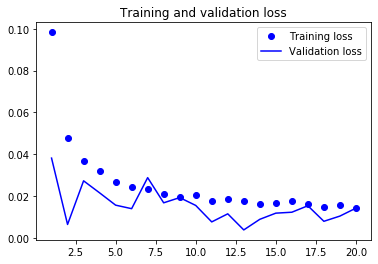

In [13]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##  Saving a model

In [14]:
import time 
start_time = time.time()
model.fit(x=X_train,
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.05)

end_time = time.time()

processing_time = end_time - start_time

NameError: name 'X_train' is not defined

In [ ]:
model.save('mygroup.h5')

## Load model & predict (for 3rd party)

In [ ]:
from keras.models import load_model
model = load_model('mygroup.h5')
preds = model.predict(float_data[34,:60].reshape(1,1,60))
preds